In [93]:
import importlib
import ETDataInterface as et
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
import sklearn.metrics as sklm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

importlib.reload(et)

<module 'ETDataInterface' from 'c:\\Users\\joste\\Personal\\Uni\\9_Semester\\TTK4550_Fordypningsprosjekt\\Code\\Notebooks\\ETDataInterface.py'>

## Dataset load and pre processing

In [64]:
modelInterface = et.ETDataInterface()
modelData = modelInterface.GetDataset()

In [65]:
plotInterface = et.ETDataInterface(et.DataSettings(hideBlink=False))
plotData = plotInterface.GetDataset()

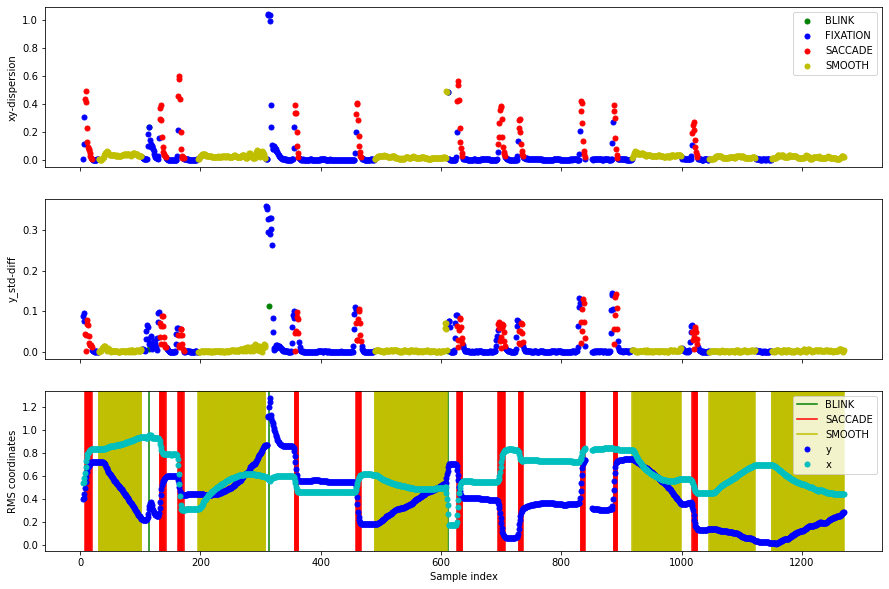

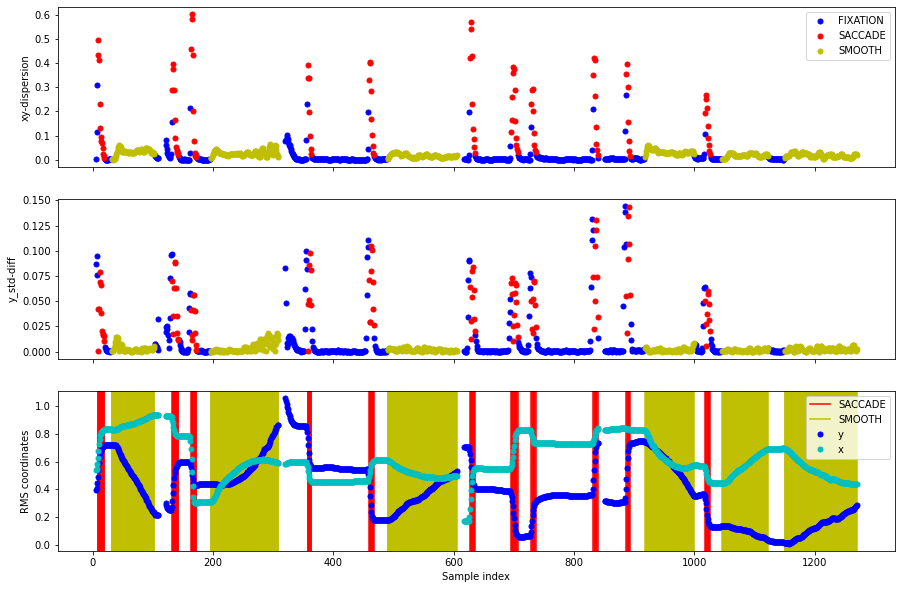

In [66]:
def plotDatasetQuality(df):
    fig, (ax1, ax2) = plt.subplots(3, 1, sharex='col')
    fig.set_figheight(10)
    fig.set_figwidth(15)
    groups = df.groupby("Label")
    colorMap = {"FIXATION": 'b', "SACCADE": 'r', "BLINK": 'g', "SMOOTH": 'y'}
    for name, group in groups:
        ax1.plot(group["sampleIndex"], group.disp, 
            marker='o', linestyle='', markersize=5, label=name, c=colorMap[name])
        # ax3.plot(group["sampleIndex"], group["y_std-diff"], 
        #     marker='o', linestyle='', markersize=5, label=name, c=colorMap[name])
        if name == "SACCADE":
            it = 0
            for x in group["sampleIndex"]:
                if it == 0:
                    ax2.axvline(x=x, c='r', label="SACCADE")
                    it = 1
                else: ax2.axvline(x=x, c='r')
        if name == "BLINK":
            it = 0
            for x in group["sampleIndex"]:
                if it == 0:
                    ax2.axvline(x=x, c='g', label="BLINK")
                    it = 1
                else: ax2.axvline(x=x, c='g')
        if name == "SMOOTH":
            it = 0
            for x in group["sampleIndex"]:
                if it == 0:
                    ax2.axvline(x=x, c='y', label="SMOOTH")
                    it = 1
                else: ax2.axvline(x=x, c='y')

    ax2.plot(df["sampleIndex"], df.y_rms, 
        marker='o', linestyle='', markersize=5, label="y", c='b')
    ax2.plot(df["sampleIndex"], df.x_rms, 
        marker='o', linestyle='', markersize=5, label="x", c='c')
    ax2.set_xlabel('Sample index')
    ax1.set_ylabel('xy-dispersion')
    # ax3.set_ylabel('y_std-diff')
    ax2.set_ylabel('RMS coordinates')
    # ax1.set_title("Dataset Quality")
    ax1.legend(loc='upper right')
    ax2.legend(loc='upper right')

%matplotlib inline
# plotDatasetQuality(plotDataset[7000:8000])
plotDatasetQuality(plotData)
plotDatasetQuality(modelData)


In [67]:
modelData["Label"] = modelData["Label"].replace({"FIXATION": 0, "SACCADE": 1, "SMOOTH": 2})
modelData = modelData.drop(["Timestamp", "delta", "sampleIndex", "x", "y"], axis=1)

# Sum of target values
train_target_sums = modelData["Label"].value_counts()
train_target_sums

2    581
0    540
1    102
Name: Label, dtype: int64

In [91]:
# Split dataset into train and validation splits
train, test, y_train, y_test = train_test_split(modelData.drop(["Label"], axis="columns"),
        modelData["Label"], test_size=0.25, shuffle=False)

## Create model and measure performance

In [186]:
%matplotlib inline
def PlotBinaryModelAUC(clf):
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(test)[:, 1])
    roc_auc = auc(fpr, tpr)

    # Plot
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("Classifier performance measure")
    plt.legend(loc="lower right")
    plt.show()    

def ShowMultiModelPerformance(clf):
    pred_proba = clf.predict_proba(test)
    pred_consensus = pd.DataFrame(pred_proba).idxmax(axis=1)
    rocAuc = roc_auc_score(y_test, pred_proba, multi_class='ovo', average="weighted")
    balancedAcc = sklm.balanced_accuracy_score(y_test, pred_consensus)
    cohenKappa = sklm.cohen_kappa_score(y_test, pred_consensus)
    precision = sklm.precision_score(y_test, pred_consensus, average=None)
    recall = sklm.recall_score(y_test, pred_consensus, average=None)
    report = sklm.classification_report(y_test, pred_consensus, target_names=["FIXATION", "SACCADE", "SMOOTH"])

    print(f"Model Performance metrics:\n \
        \tROC AUC: \t\t{round(rocAuc, 2)}\t\t\t\t[0.0,1.0]\n \
        \tBalanced accuracy: \t{round(balancedAcc, 2)}\t\t\t\t[0.0,1.0]\n \
        \tCohen Kappa: \t\t{round(cohenKappa, 2)}\t\t\t\t[-1.0,1.0]\n \
        \tPrecision score: \tFi: {round(precision[0], 2)}, Sa: {round(precision[1], 2)}, Sm: {round(precision[2], 2)}\t[-1.0,1.0]\n \
        \tRecall score: \t\tFi: {round(recall[0], 2)}, Sa: {round(recall[1], 2)}, Sm: {round(recall[2], 2)}\t[-1.0,1.0]\n \
        ")

    print(report)

    confusionMatrix = sklm.confusion_matrix(y_test, pred_consensus)
    confusionMatrixNorm1 = sklm.confusion_matrix(y_test, pred_consensus, normalize="true")
    confusionMatrixNorm2 = sklm.confusion_matrix(y_test, pred_consensus, normalize="pred")

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey='row')
    fig.suptitle('Confusion matrices', fontsize=16)
    ax1.matshow(confusionMatrix)
    ax1.set_title("Unnormalized")
    ax1.set_ylabel("True")
    ax1.set_xlabel("Pred")
    for (i, j), z in np.ndenumerate(confusionMatrix):
        ax1.text(j, i, z, ha='center', va='center')

    ax2.matshow(confusionMatrixNorm1)
    ax2.set_title("True-normalized")
    ax2.set_xlabel("Pred")
    for (i, j), z in np.ndenumerate(confusionMatrixNorm1):
        ax2.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')
        
    ax3.matshow(confusionMatrixNorm2)
    ax3.set_title("Pred-normalized")
    ax3.set_xlabel("Pred")
    for (i, j), z in np.ndenumerate(confusionMatrixNorm2):
        ax3.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')

def PlotFeatureImportances(clf):
    clfFeatures = clf.feature_names_in_
    importances = clf.feature_importances_
    indices = np.argsort(importances)
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [clfFeatures[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

Model Performance metrics:
         	ROC AUC: 		0.99				[0.0,1.0]
         	Balanced accuracy: 	0.95				[0.0,1.0]
         	Cohen Kappa: 		0.81				[-1.0,1.0]
         	Precision score: 	Fi: 0.75, Sa: 0.82, Sm: 0.99	[-1.0,1.0]
         	Recall score: 		Fi: 0.94, Sa: 1.0, Sm: 0.91	[-1.0,1.0]
         
              precision    recall  f1-score   support

    FIXATION       0.75      0.94      0.83        64
     SACCADE       0.82      1.00      0.90         9
      SMOOTH       0.99      0.91      0.95       233

    accuracy                           0.92       306
   macro avg       0.85      0.95      0.89       306
weighted avg       0.94      0.92      0.92       306



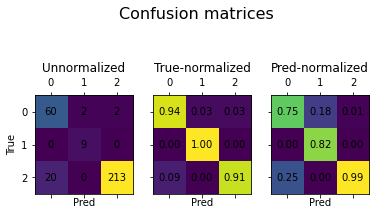

In [187]:
clf = RandomForestClassifier(
    n_jobs=-1,
    class_weight="balanced",
    criterion="entropy"
    )
clf.fit(train, y_train)

# PlotModelAUC(clf)
# PlotModelThresholds(clf)
# PlotFeatureImportances(clf)
ShowMultiModelPerformance(clf)

# clf = GradientBoostingClassifier()
# clf.fit(train, y_train)

# PlotModelAUC(clf, "GradientBoostingClassifier")

In [89]:
# fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(test)[:, 1])

# best_thresh = 0
# best_tpr = 0
# best_ratio = 0
# for i in range(len(thresholds)):
#     if fpr[i] == 0 : continue
#     if tpr[i]/fpr[i] > best_ratio:
#         best_ratio = tpr[i]/fpr[i]
#         best_thresh = thresholds[i]
#         best_tpr = tpr[i]
#         best_fpr = fpr[i]

predictions = clf.predict_proba(test)
prediction_results = pd.DataFrame({
    "o_index": y_test.index,
    "y": y_test.reset_index(drop=True),
    "y_pred": pd.DataFrame(predictions).idxmax(axis=1),
    "certainty": pd.DataFrame(predictions).max(axis=1)
    })
